In [1]:
import pandas as pd
import sys
import os
import numpy as np
import signatureanalyzer as sa
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../funcs")

from features import snvs, deletions, amplifications, translocations, hyperdiploidy, trisomies
from features import filt_snvs
from features import pathways, biallelic, myc, patient_metadata, clinical_metadata
import smm_utils as smm
import plot as pl

/home/sanand/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
DFCI_SURVIVAL = "../data/raw/SMM_progression_analysis_final_manuscript2.txt"
MAYO_COHORT = "../data/val_cohorts/Mayo_cohort_SMM_cleaned.txt"
NYC_COHORT = "../data/val_cohorts/GM_cohort_SMM_cleaned.txt"

## 1. Load SMM Cohort
---

In [3]:
def _assign_severity(x):
    if x in ("C2","C3","C5"):
        return 'High'
    elif x in ("C1","C6"):
        return "Intermediate"
    else:
        return "Low"
    
def _assign_mayo(x):
    if x==1:
        return "Low"
    elif x==2:
        return "Intermediate"
    elif x==3:
        return "High"
    else:
        return None

In [4]:
X_v2_df = pd.read_csv(os.path.join("../Fig1/supplement", "table3a_smm_filt_v2_matrix.tsv"), sep='\t', index_col=0)
clust_df = pd.read_csv(os.path.join("../Fig1/supplement", "table4_sample_cluster_id.tsv"), sep='\t', index_col=0)

clust_df['high_risk_clust'] = clust_df['consensus_nmf'].isin(["C2","C3","C5"])
clust_df['risk_lvl'] = clust_df['consensus_nmf'].apply(lambda x: _assign_severity(x))
clust_df['risk_bin'] = clust_df['risk_lvl'].apply(lambda x: "High" if x=="High" else "Low")

In [5]:
X_df = pd.read_csv("../data/raw/SMM_study_final_list_detailed_github.txt", sep='\t',index_col=0)

numerical_entries = (snvs, deletions, amplifications + ['6p_amp'], translocations, hyperdiploidy, myc, trisomies)
metadata_entries = (patient_metadata, pathways, clinical_metadata)

num_set = [i for sub in numerical_entries for i in sub]
meta_set = [i for sub in metadata_entries for i in sub]

num_set.remove("amp_11_isolated")

X_detailed_df = X_df[num_set].loc[clust_df.index].fillna(0).astype(int)
X_detailed_df = X_detailed_df.join(X_v2_df["amp_11_isolated"])

In [6]:
MIN_FEATS = 3
FILTER_TRISOMIES = True

## 2. Align Mayo Cohort
---

In [7]:
CNV_DICT = {
    'del_1p':'1p_del',
    'gain_1q':'1q_gain',
    '3 gain':'Tri_3',
    '4 gain':'Tri_4',
    '5 gain':'Tri_5',
    'gain_6p':'6p_amp',
    'del_6q':'6q_del',
    '7 gain':'Tri_7',
    '8p del':'del_8p', 
    '8q gain':'8q24 amp', 
    '9 gain':'Tri_9',
    '11 gain':'Tri_11',
    'del_13q':'13q del',
    'del_14q':'14q_del',
    #'14q gain':'', 
    '15q gain':'Tri_15',
    'del_16q':'16q_del',
    #'16 gain':'', 
    '17 gain':'Tri_17',
    'del_17p':'17p_del',
    'del_18q':'del_18q',
    '18 gain':'Tri_18', 
    '19 gain':'Tri_19', 
    '21 gain':'Tri_21',
    '22q del':'del_22q',
    'HRD.CALL':'HRD',
    'amp8q24':'8q24 amp', 
}

TX_DICT = {
    'tx.11.14':"t(11;14)", 
    'tx4.14':"t(4;14)", 
    'tx.14.16':"t(14;16)",
    'tx.14.20':"t(14;20)", 
    'tx.6.14':"t(6;14)",
}

PATIENT = [
    'Progression_Status', 'Sample_ID', 'AGE', 'SEX', 'Rev_surv','New_Mayo_model','TTP','Cohort'
]

In [8]:
mayo_val_df = pd.read_csv(MAYO_COHORT, sep='\t').set_index("Patient_ID")
mayo_val_df.columns = [x.strip() for x in mayo_val_df.columns]
mayo_val_df = mayo_val_df.rename(columns=CNV_DICT).rename(columns=TX_DICT)
mayo_val_df["New_Mayo_model"] = mayo_val_df["New_Mayo_model"].apply(lambda x: _assign_mayo(x))
mayo_val_df['Cohort'] = "MAYO"

# Intersecting Features
features_to_use = np.intersect1d(mayo_val_df.columns, X_detailed_df.columns)
if FILTER_TRISOMIES: 
    features_to_use = set(features_to_use)-{x for x in features_to_use if x.startswith('Tri')}
features_to_use = list(features_to_use)

print("{} features intersecting".format(len(features_to_use)))

# Remove MM Cases
mayo_val_df = mayo_val_df.drop(index=['s_28251','s_29115','s_29170','s_29181'])

# Create Matrices
mayo_val_X_df = mayo_val_df[features_to_use]
mayo_val_patient_df = mayo_val_df[PATIENT]

47 features intersecting


## 3. Align NY Cohort
---

In [9]:
CNV_DICT = {
    'Chr_2_gain':'Chr_2_gain', 
    'Tri_3':'Tri_3', 
    'Tri_4':'Tri_4', 
    'Tri_5':'Tri_5', 
    'Tri_7':'Tri_7', 
    'Tri_9':'Tri_9', 
    'Tri_11':'Tri_11', 
    'Tri_15':'Tri_15', 
    'Tri_17':'Tri_17', 
    'Tri_18':'Tri_18', 
    'Tri_19':'Tri_19', 
    'Tri_21':'Tri_21',
    'gain_1q':'1q_gain', 
    'amp_2p':'2p_amp', 
    'amp8q24':'8q24 amp', 
    'del_1p':'1p_del', 
    'del_4q':'del_4q', 
    'del_6q':'6q_del', 
    'del_8p':'del_8p', 
    'del_11q':'11q_del', 
    'del_13q':'13q del', 
    'del_14q':'14q_del', 
    'del_16q':'16q_del', 
    'del_17p':'17p_del', 
    'del_20q':'del_20q', 
    'del_22q':'del_22q',
}

PATIENT = ['Cohort', 'Sequencing_platform', 'Other_ID', 'Sample_ID', 'AGE', 'SEX',
          'Progression_Status', 'TTP', 'Survival_status', 
            'OS_time', 'Rev_surv', 'New_Mayo_model'
]

In [10]:
ny_val_df = pd.read_csv(NYC_COHORT, sep='\t').set_index("Patient_ID")
ny_val_df.columns = [x.strip() for x in ny_val_df.columns]
ny_val_df = ny_val_df.rename(columns=CNV_DICT)
ny_val_df["New_Mayo_model"] = ny_val_df["New_Mayo_model"].apply(lambda x: _assign_mayo(x))
ny_val_df['Cohort'] = "NYU"

# Intersecting Features
features_to_use = np.intersect1d(ny_val_df.columns, X_detailed_df.columns)
if FILTER_TRISOMIES:
    features_to_use = set(features_to_use)-{x for x in features_to_use if x.startswith('Tri')}
features_to_use = list(features_to_use)

print("{} features intersecting".format(len(features_to_use)))

# Create Matrices
ny_val_X_df = ny_val_df[features_to_use]
ny_val_patient_df = ny_val_df[PATIENT]

57 features intersecting


## 4. Intersect Feature Space
---

In [11]:
def _p(s):
    print("Ours: ")
    print([x for x in X_detailed_df if s in x])
    
    print("Mayo: ")
    print([x for x in mayo_val_df if s in x])
    
    print("NYU: ")
    print([x for x in ny_val_df if s in x])

In [12]:
features_to_use = set(np.intersect1d(mayo_val_X_df.columns, ny_val_X_df.columns))

# Filter by min features
gb = X_detailed_df[features_to_use].sum(0).sort_values() >= MIN_FEATS
features_to_use = list(gb[gb].index) + ['t(6;14)']
print("    * {}/{} features found in  >= {} patients in DFCI \n ".format(len(features_to_use), gb.shape[0], MIN_FEATS))

# Filtered Matrices
train_df = X_detailed_df[features_to_use]
test_ny_df = ny_val_X_df[features_to_use]
test_mayo_df = mayo_val_X_df[features_to_use]

print(" DFCI: {} samples x {} features.".format(*train_df.shape))
print(" NYU: {} samples x {} features.".format(*test_ny_df.shape))
print(" MAYO: {} samples x {} features.".format(*test_mayo_df.shape))

    * 36/42 features found in  >= 3 patients in DFCI 
 
 DFCI: 214 samples x 36 features.
 NYU: 75 samples x 36 features.
 MAYO: 67 samples x 36 features.


## 5. Train RF Classifier
---

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#### Initial Model

* No hyperparameter optimization

In [14]:
LABEL = 'risk_lvl'

In [15]:
model_risk = RandomForestClassifier(random_state=42)

# Cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Score
n_scores = cross_val_score(
    model_risk, 
    train_df.values, 
    clust_df[LABEL].values, 
    scoring='accuracy', 
    cv=cv, 
    n_jobs=-1, 
    error_score='raise'
)

# report performance
print('DFCI Training Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
model_risk.fit(train_df.values, clust_df[LABEL].values)

# test datasets
mayo_val_patient_df[LABEL] = model_risk.predict(test_mayo_df.values)
ny_val_patient_df[LABEL] = model_risk.predict(test_ny_df.values)

DFCI Training Accuracy: 0.911 (0.040)


In [16]:
LABEL = 'consensus_nmf'

In [17]:
model_clust = RandomForestClassifier(random_state=42)

# Cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Score
n_scores = cross_val_score(
    model_clust, 
    train_df.values, 
    clust_df[LABEL].values, 
    scoring='accuracy', 
    cv=cv, 
    n_jobs=-1, 
    error_score='raise'
)

# report performance
print('DFCI Training Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
model_clust.fit(train_df.values, clust_df[LABEL].values)

# test datasets
mayo_val_patient_df[LABEL] = model_clust.predict(test_mayo_df.values)
ny_val_patient_df[LABEL] = model_clust.predict(test_ny_df.values)

DFCI Training Accuracy: 0.866 (0.048)


In [18]:
LABEL = 'risk_bin'

In [19]:
model_bin = RandomForestClassifier(random_state=42)

# Cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Score
n_scores = cross_val_score(
    model_bin, 
    train_df.values, 
    clust_df[LABEL].values, 
    scoring='accuracy', 
    cv=cv, 
    n_jobs=-1, 
    error_score='raise'
)

# report performance
print('DFCI Training Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
model_bin.fit(train_df.values, clust_df[LABEL].values)

# test datasets
mayo_val_patient_df[LABEL] = model_bin.predict(test_mayo_df.values)
ny_val_patient_df[LABEL] = model_bin.predict(test_ny_df.values)

DFCI Training Accuracy: 0.932 (0.035)


## 6. Feature Importance
---

In [20]:
feats_df = pd.DataFrame(model_clust.feature_importances_, index=train_df.columns, columns=['weight'])
feats_df['n'] = X_detailed_df.sum(0)

In [21]:
from typing import Union

def labeled_scatterplot(
    df: pd.DataFrame, 
    xlab: str, 
    ylab: str, 
    ax: plt.axes = None, 
    figsize: tuple = (6,6), 
    xlim: Union[None, float] = None, 
    ylim: Union[None,float] = None, 
    lab_size:int = 8
    ):
    """
    Labeled Scatterplot.
    """
    from adjustText import adjust_text

    assert xlab in df, "{} not in input dataframe".format(xlab)
    assert ylab in df, "{} not in input dataframe".format(ylab)
    
    if ax is None:
        fig,ax = plt.subplots(figsize=figsize)
    
    if xlim is None:
        xlim = np.max(df[xlab])
    if ylim is None:
        ylim = np.max(df[ylab])
        
    ax.scatter(
        feats_df[xlab], 
        feats_df[ylab], 
        s=50, 
        c='lightblue', 
        edgecolor='black', 
        alpha=0.5
    )

    texts = list()
    for i,txt in enumerate(feats_df.index):
        if feats_df.iloc[i][xlab] > xlim or feats_df.iloc[i][ylab] > ylim:
            texts.append(
                ax.text(
                    feats_df.iloc[i][xlab], 
                    feats_df.iloc[i][ylab], 
                    txt, 
                    ha='center', 
                    va='center', 
                    fontsize=lab_size,
                    bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round', alpha=0.2)
                )
            )
    
    if len(texts)>0:
        ax.axhline(ylim, c='grey', alpha=0.8, linewidth=0.25)
        ax.axvline(xlim, c='grey', alpha=0.8, linewidth=0.25)
        adjust_text(texts)

    ax.set_xlabel("# in Dataset", fontsize=14)
    ax.set_ylabel("Feature Importance in RF Classifier", fontsize=14)
    
    return fig

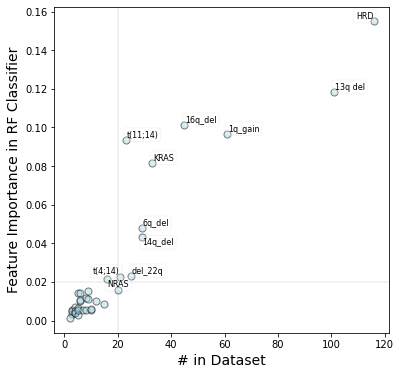

In [22]:
_ = labeled_scatterplot(feats_df, "n", "weight", xlim=20, ylim=0.02)
plt.savefig("figures/SX_RF_feat_importance.pdf", dpi=100, bbox_inches='tight')

## 7. Aggregate
---

In [31]:
mapping_df = pd.read_csv("../data/raw/SMM_study_sample_map.tsv", sep='\t',index_col=0)

# DFCI Cohort
dfci_patient_df = pd.read_csv(DFCI_SURVIVAL, sep='\t').set_index("Patient_ID")
dfci_patient_df = dfci_patient_df.rename(index={
    "SMM83":"SMM_043_Tumor",
    "SMM84":"SMM_025_Tumor",
    "SMM97":"SMM_056_Tumor",
}).join(mapping_df[['id']]).set_index("id")

dfci_patient_df["New_Mayo_model"] = dfci_patient_df["New_Mayo_model"].apply(lambda x: _assign_mayo(x))

In [32]:
comb_df = pd.concat([
    dfci_patient_df,
    mayo_val_patient_df,
    ny_val_patient_df,

])

comb_df = comb_df[['Cohort','New_Mayo_model','SEX','consensus_nmf','TTP','Progression_Status','Rev_surv']]

In [33]:
# Drop Missing Mayo Cohort with no Mayo 2020 Annotation
comb_df[comb_df["New_Mayo_model"].isna()]

,Cohort,New_Mayo_model,SEX,consensus_nmf,TTP,Progression_Status,Rev_surv
GM_9,NYU,None,Female,C5,4.810404,1,0


In [34]:
comb_df.to_csv("supplement/SMM_combined_subtypes_survival.tsv", sep='\t')